# Extract WAV Characteristics

In [68]:
import numpy as np
import os
import os.path
import sys
import librosa
from scipy.io import wavfile
import pandas as pd
import librosa
import pretty_midi
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2
import keras
from keras.models import load_model
from keras import layers


mode = "DNN"
source_folder = "/media/scar-face/Windows/Hopefully the final implementation/Testing Songs/Beethoven Fur Elise"
innermost_folder = os.path.basename(os.path.normpath(source_folder))
output_directory = source_folder+'/'
weights_dir = "/media/scar-face/Windows/Hopefully the final implementation/Datasplit/weights_CQT/weights/"
def get_first_midi_file(directory):
    for file in os.listdir(directory):
        if file.endswith('.mid'):
            return os.path.join(directory, file)
    return None

def get_first_audio_file(directory):
    for file in os.listdir(directory):
        if file.endswith('.wav'):
            return os.path.join(directory, file)
    return None

audio_file_path = get_first_audio_file(output_directory)
original_midi_path = get_first_midi_file(output_directory)

In [70]:


hop_length = 512
bin_number = 252
bins_per_octave = 36
window_step = 0.01
number_notes = 88
length_per_file = 4000000

os.makedirs(output_directory, exist_ok=True)
train_to_npyarray = []
counter = 0


folder_name = os.path.basename(os.path.normpath(source_folder))
print('Folder name is: ', folder_name)


for root, dirs, files in os.walk(source_folder):
    for filename in files:
        if filename.endswith('.wav'):
            wav_path = os.path.join(root, filename)

            print("Processing " + wav_path)


            try:
                sampling_freq, stereo_vector = wavfile.read(wav_path)
            except Exception as e:
                print("Wave file error: ", wav_path, str(e))
                continue

          
            mono_vector = np.mean(stereo_vector, axis=1)

            
            cqt_feat = np.absolute(librosa.cqt(mono_vector, sr=sampling_freq, hop_length=hop_length, n_bins=bin_number, bins_per_octave=bins_per_octave)).transpose()


            while (len(train_to_npyarray) + len(cqt_feat)) >= length_per_file:
                size_to_add = length_per_file - len(train_to_npyarray)
                train_to_npyarray.extend(cqt_feat[0:size_to_add, :])
                
                train_to_npyarray = np.array(train_to_npyarray)
               

                print("Shape of spec is " + str(train_to_npyarray.shape) + " - Saved in " + folder_name + '/' + str(counter) + folder_name)
                

                
                np.save(os.path.join(output_directory, f'{counter}{folder_name}_CQT_X'), train_to_npyarray)
                


                counter += 1
                train_to_npyarray = []
                cqt_feat = cqt_feat[size_to_add:, :]
           

            if len(cqt_feat) == length_per_file:
                train_to_npyarray.extend(cqt_feat)
               
                train_to_npyarray = np.array(train_to_npyarray)
                

                print("Shape of spec is " + str(train_to_npyarray.shape) + " - Saved in " + folder_name + '/' + str(counter) + folder_name)
                

                np.save('{}_X'.format('../script/' + str(counter) + folder_name), train_to_npyarray)
                

                counter += 1
                train_to_npyarray = []
               

            elif len(cqt_feat) > 0:
                train_to_npyarray.extend(cqt_feat)
                

train_to_npyarray = np.array(train_to_npyarray)


if len(train_to_npyarray) > 0:
    print("Shape of spec is " + str(train_to_npyarray.shape) + " - Saved in " + output_directory + f'{counter}{folder_name}_CQT_X.npy')
    np.save(os.path.join(output_directory, f'{counter}{folder_name}_CQT_X'), train_to_npyarray)


Folder name is:  Beethoven Fur Elise
Processing /media/scar-face/Windows/Hopefully the final implementation/Testing Songs/Beethoven Fur Elise/Beethoven-Fur Elise.wav
Processing /media/scar-face/Windows/Hopefully the final implementation/Testing Songs/Beethoven Fur Elise/Song_CQT_DNN.wav
Shape of MFCC is (7780, 252) - Saved in /media/scar-face/Windows/Hopefully the final implementation/Testing Songs/Beethoven Fur Elise/0Beethoven Fur Elise_CQT_X.npy


In [76]:
source = ''

train_folder = output_directory

mean_X = []
min_X = []
max_X = []

print ("Get max - min ")
# Iterate on every file
for filename in os.listdir(source + train_folder):
    if innermost_folder+"_CQT_X" in filename:
        X_train = np.load(source + train_folder + filename)
        print ("X_train shape:", X_train.shape)
        max_X.append(X_train.max())
        min_X.append(X_train.min())
        
max_train = max(max_X)
min_train = min(min_X)

print (min_train)
print (max_train)

Get max - min 
X_train shape: (7780, 252)
0.0
4.0518103


# Predict Values

In [72]:
np.random.seed(250)  
mini_batch_size, num_epochs = 100, 50
input_size = 252
number_units = 256
number_layers = 3
number_classes = 88
size_samples = 100
data_directory = output_directory
model_type = "dnn"
X = []
y = []

num_test_batches = 1

def slide_cnn_window(X_train):
    window_size = 7
    length, feature_length = X_train.shape
    
    padding = np.pad(X_train, ((window_size // 2,window_size // 2), (0,0)), 'constant', constant_values = 0)
    
    for k in range(0, -window_size , -1):
        tmp = np.roll(padding, k, axis = 0)

        if k == 0:
            X_train = tmp[:length, :]
        else:
            X_train = np.concatenate((X_train, tmp[:length, :]), axis = 1)
    X_train = np.reshape(X_train, (length, -1, feature_length, 1))
    return X_train

print ('Loading test data')
for i in range(num_test_batches):
    x_file_name =  innermost_folder+"_CQT_X.npy"
    print ("Batching..." + str(i) + x_file_name)
    X_test = np.array(np.load(data_directory + str(i) + x_file_name ))
    if i == 0:
        X = X_test
    else:
        X = np.concatenate((X,X_test), axis = 0)
    if model_type == 'cnn':
        X = slide_cnn_window(X)

# Load the model 
model = load_model(weights_dir + "weights_CQT_"+mode+".hdf5")
TP = 0
FP = 0
FN = 0

print ("Predicting model. . . ")
predictions = model.predict(X, batch_size=mini_batch_size, verbose = 1) 
predictions = np.array(predictions).round()
predictions[predictions > 1] = 1
np.save(f'{output_directory}predictions_CQT_{mode}.npy', predictions)


Loading test data
Batching...0Beethoven Fur Elise_CQT_X.npy


/home/scar-face/Documents/GitHub/Thesis-live/Models/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicting model. . . 
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Cleaning model . . .
Calculating accuracy after cleaning. . .


# NPY to MIDI

Precision: 0.0528
Recall: 0.1003
F1 Score: 0.0692
Accuracy: 0.9761


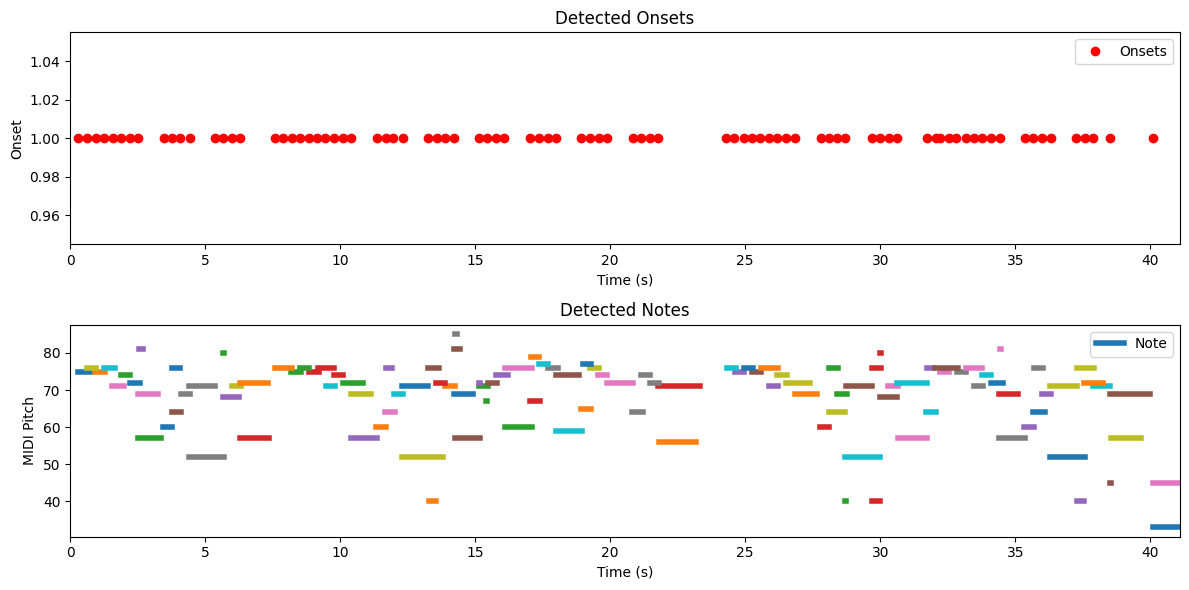

In [73]:
import numpy as np
import librosa
import pretty_midi
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


data_dir = output_directory+"predictions_post_CQT_"+mode+".npy"
matY = np.load(data_dir)
#audio_file_path = output_directory+"Silent.wav"
#original_midi_path = output_directory+"Silent.mid" 

y, sampleRate = librosa.load(audio_file_path, sr=None)  


output_dir = output_directory+"Song_CQT_"+mode

def calculate_tempo(y, sampleRate):
    tempo, beats = librosa.beat.beat_track(y=y, sr=sampleRate)
    first_beat_time, last_beat_time = librosa.frames_to_time((beats[0], beats[-1]), sr=sampleRate)
    tempo_calculated = 60 / ((last_beat_time - first_beat_time) / (len(beats) - 1))
    
    if np.isnan(tempo_calculated):
        tempo = 120 
    else:
        tempo = round(tempo_calculated)  


    while tempo > 400:
        tempo //= 2
    return tempo


MyMIDI = pretty_midi.PrettyMIDI()
tempo = calculate_tempo(y, sampleRate)  
MyMIDI.tempo = tempo  

instrument = pretty_midi.Instrument(program=0)

frame_width = 512.0
sample_frequence = sampleRate
pitch = 20


onset_frames = librosa.onset.onset_detect(y=y, sr=sampleRate, units='frames', backtrack=True)
onset_times = librosa.frames_to_time(onset_frames, sr=sampleRate)


for col in np.transpose(matY):
    startTime = 0.0
    endTime = 0.0
    pitch += 1
    status = False

    for idx, i in enumerate(col):
        if i > 0.5 and not status:
            startTime = idx * frame_width / sample_frequence
            status = True
        if i < 0.1 and status:
            endTime = idx * frame_width / sample_frequence
            status = False
            if endTime - startTime > 0.02:
               
                if any(np.abs(onset_times - startTime) < 0.05): 
                    note = pretty_midi.Note(
                        velocity=100, pitch=pitch, start=startTime, end=endTime)
                    instrument.notes.append(note)

    if status:
        if (len(col) * frame_width - 0.5) / sample_frequence - startTime > 0.02:
            endTime = (len(col) * frame_width - 0.5) / sample_frequence
            if any(np.abs(onset_times - startTime) < 0.05):  
                note = pretty_midi.Note(
                    velocity=100, pitch=pitch, start=startTime, end=endTime)
                instrument.notes.append(note)


MyMIDI.instruments.append(instrument)


MyMIDI.write(output_dir + '.mid')


with open(output_dir + '.txt', 'w') as file:
    for note in instrument.notes:
        file.write(f"{note.start}, {note.end}, {note.pitch}\n")


original_midi = pretty_midi.PrettyMIDI(original_midi_path)
original_notes = original_midi.instruments[0].notes

frame_duration = frame_width / sample_frequence  
num_frames = int(np.ceil(len(y) / frame_width))

def notes_to_frames(notes, num_frames, frame_duration):
    frames = np.zeros((num_frames, 88))  
    for note in notes:
        start_frame = int(note.start // frame_duration)
        end_frame = int(note.end // frame_duration)
        pitch_idx = note.pitch - 21  
        frames[start_frame:end_frame + 1, pitch_idx] = 1 
    return frames


original_frames = notes_to_frames(original_notes, num_frames, frame_duration)
predicted_frames = notes_to_frames(instrument.notes, num_frames, frame_duration)


y_true = original_frames.flatten()
y_pred = predicted_frames.flatten()


precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title("Detected Onsets")
plt.plot(onset_times, np.ones_like(onset_times), 'ro', label='Onsets')
plt.xlim(0, max(onset_times) + 1)
plt.xlabel("Time (s)")
plt.ylabel("Onset")
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Detected Notes")
for note in instrument.notes:
    plt.plot([note.start, note.end], [note.pitch, note.pitch], lw=4)

plt.xlim(0, max(onset_times) + 1)
plt.xlabel("Time (s)")
plt.ylabel("MIDI Pitch")
plt.legend(["Note"])
plt.tight_layout()
plt.show()


In [55]:

data_dir = output_directory+"predictions_post_CQT_"+mode+".npy"
matY = np.load(data_dir)


y, sampleRate = librosa.load(audio_file_path, sr=None) 

output_dir = output_directory+"Song_CQT_"+mode


original_midi = pretty_midi.PrettyMIDI(original_midi_path)
original_notes = original_midi.instruments[0].notes

frame_width = 512.0
sample_frequence = sampleRate
pitch = 20


onset_frames = librosa.onset.onset_detect(y=y, sr=sampleRate, units='frames', backtrack=True)
onset_times = librosa.frames_to_time(onset_frames, sr=sampleRate)


def notes_to_frames(notes, num_frames, frame_duration):
    frames = np.zeros((num_frames, 88))  
    for note in notes:
        start_frame = int(note.start // frame_duration)
        end_frame = int(note.end // frame_duration)
        pitch_idx = note.pitch - 21  
        frames[start_frame:end_frame + 1, pitch_idx] = 1  
    return frames


instrument = pretty_midi.Instrument(program=0)

for col in np.transpose(matY):
    startTime = 0.0
    endTime = 0.0
    pitch += 1
    status = False

    for idx, i in enumerate(col):
        if i > 0.5 and not status:
            startTime = idx * frame_width / sample_frequence
            status = True
        if i < 0.1 and status:
            endTime = idx * frame_width / sample_frequence
            status = False
            if endTime - startTime > 0.02:
                note = pretty_midi.Note(
                    velocity=100, pitch=pitch, start=startTime, end=endTime)
                instrument.notes.append(note)

    if status:
        if (len(col) * frame_width - 0.5) / sample_frequence - startTime > 0.02:
            endTime = (len(col) * frame_width - 0.5) / sample_frequence
            note = pretty_midi.Note(
                velocity=100, pitch=pitch, start=startTime, end=endTime)
            instrument.notes.append(note)


num_frames = int(np.ceil(len(y) / frame_width))
frame_duration = frame_width / sample_frequence

original_frames = notes_to_frames(original_notes, num_frames, frame_duration)
predicted_frames = notes_to_frames(instrument.notes, num_frames, frame_duration)


y_true = original_frames.flatten()
y_pred = predicted_frames.flatten()


precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

print("Initial Metrics (with False Positives):")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Number of Detected Notes (Initial): {len(instrument.notes)}")

instrument_cleaned = pretty_midi.Instrument(program=0)  

for note in instrument.notes:
    if any(np.abs(onset_times - note.start) < 0.05):  
        instrument_cleaned.notes.append(note)


cleaned_frames = notes_to_frames(instrument_cleaned.notes, num_frames, frame_duration)

y_pred_cleaned = cleaned_frames.flatten()

precision_cleaned, recall_cleaned, f1_score_cleaned, _ = precision_recall_fscore_support(y_true, y_pred_cleaned, average='binary')
accuracy_cleaned = accuracy_score(y_true, y_pred_cleaned)

print("\nMetrics After False Positives Removal:")
print(f"Precision: {precision_cleaned:.4f}")
print(f"Recall: {recall_cleaned:.4f}")
print(f"F1 Score: {f1_score_cleaned:.4f}")
print(f"Accuracy: {accuracy_cleaned:.4f}")
print(f"Number of Detected Notes (After False Positives Removal): {len(instrument_cleaned.notes)}")


Initial Metrics (with False Positives):
Precision: 0.2326
Recall: 0.9819
F1 Score: 0.3761
Accuracy: 0.9621
Number of Detected Notes (Initial): 1037

Metrics After False Positives Removal:
Precision: 0.2637
Recall: 0.9334
F1 Score: 0.4113
Accuracy: 0.9689
Number of Detected Notes (After False Positives Removal): 854


In [56]:

tempo = original_midi.estimate_tempo()


num_original_notes = len(original_notes)


print(f"Original Tempo: {tempo:.2f} BPM")
print(f"Number of Notes (Ground Truth): {num_original_notes}")


y_true = original_frames.flatten()
y_pred = predicted_frames.flatten()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)


print("\nInitial Metrics (with False Positives):")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Number of Detected Notes (Initial): {len(instrument.notes)}")


instrument_cleaned = pretty_midi.Instrument(program=0)  

for note in instrument.notes:
    if any(np.abs(onset_times - note.start) < 0.05):  
        instrument_cleaned.notes.append(note)


cleaned_frames = notes_to_frames(instrument_cleaned.notes, num_frames, frame_duration)


y_pred_cleaned = cleaned_frames.flatten()


precision_cleaned, recall_cleaned, f1_score_cleaned, _ = precision_recall_fscore_support(y_true, y_pred_cleaned, average='binary')
accuracy_cleaned = accuracy_score(y_true, y_pred_cleaned)

print("\nMetrics After False Positives Removal:")
print(f"Precision: {precision_cleaned:.4f}")
print(f"Recall: {recall_cleaned:.4f}")
print(f"F1 Score: {f1_score_cleaned:.4f}")
print(f"Accuracy: {accuracy_cleaned:.4f}")
print(f"Number of Detected Notes (After False Positives Removal): {len(instrument_cleaned.notes)}")


Original Tempo: 189.00 BPM
Number of Notes (Ground Truth): 384

Initial Metrics (with False Positives):
Precision: 0.2326
Recall: 0.9819
F1 Score: 0.3761
Accuracy: 0.9621
Number of Detected Notes (Initial): 1037

Metrics After False Positives Removal:
Precision: 0.2637
Recall: 0.9334
F1 Score: 0.4113
Accuracy: 0.9689
Number of Detected Notes (After False Positives Removal): 854


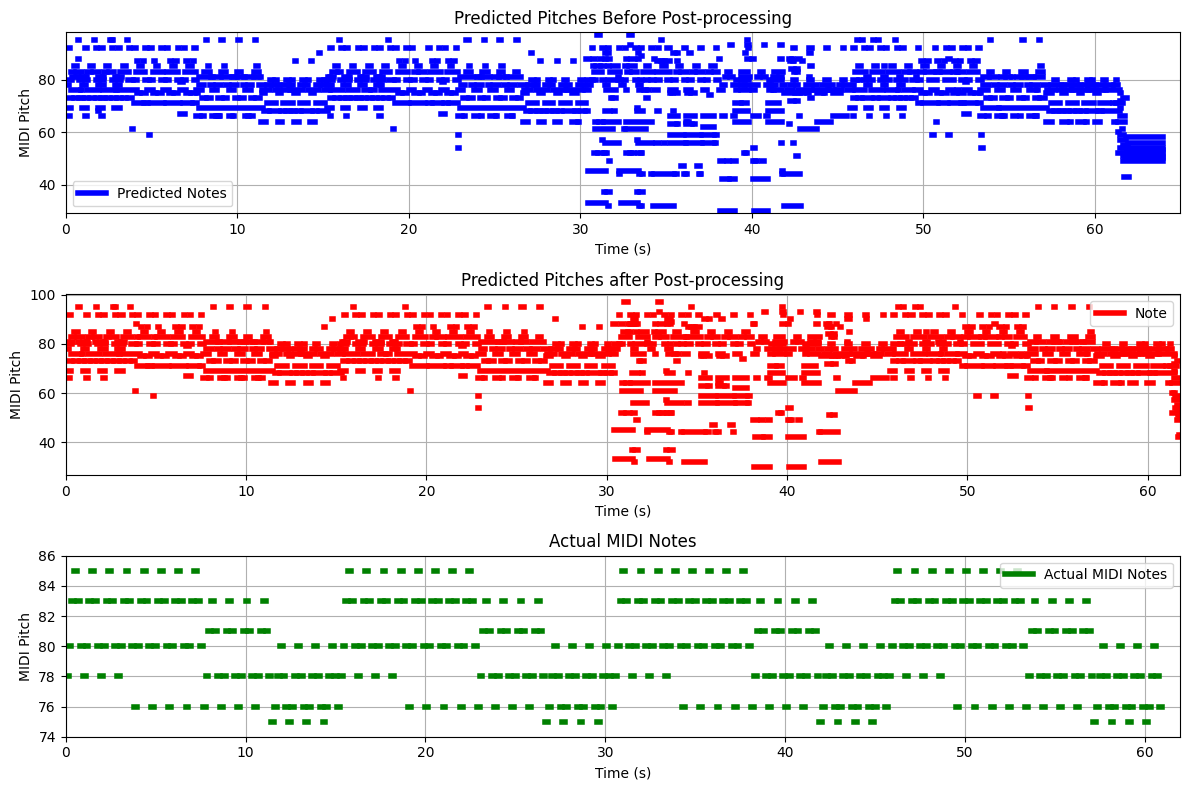

In [59]:



data_dir = output_directory+"predictions_post_CQT_"+mode+".npy"
matY = np.load(data_dir)


y, sampleRate = librosa.load(audio_file_path, sr=None)  
original_midi = pretty_midi.PrettyMIDI(original_midi_path)
original_notes = original_midi.instruments[0].notes  


onset_frames = librosa.onset.onset_detect(y=y, sr=sampleRate, units='frames', backtrack=True)
onset_times = librosa.frames_to_time(onset_frames, sr=sampleRate)


frame_width = 512.0
sample_frequence = sampleRate
pitch = 20


predicted_pitches = []
predicted_start_times = []
predicted_end_times = []


for col in np.transpose(matY):
    startTime = 0.0
    endTime = 0.0
    pitch += 1
    status = False

    for idx, i in enumerate(col):
        if i > 0.5 and not status:  
            startTime = idx * frame_width / sample_frequence
            status = True
        if i < 0.1 and status: 
            endTime = idx * frame_width / sample_frequence
            status = False
            if endTime - startTime > 0.02:  
                predicted_start_times.append(startTime)
                predicted_end_times.append(endTime)
                predicted_pitches.append(pitch)

    if status:  
        endTime = (len(col) * frame_width - 0.5) / sample_frequence
        if endTime - startTime > 0.02:
            predicted_start_times.append(startTime)
            predicted_end_times.append(endTime)
            predicted_pitches.append(pitch)


plt.figure(figsize=(12, 8))


plt.subplot(3, 1, 1)
plt.title("Predicted Pitches Before Post-processing")
for start, end, pitch in zip(predicted_start_times, predicted_end_times, predicted_pitches):
    plt.plot([start, end], [pitch, pitch], lw=4, color='b')

plt.xlim(0, max(predicted_end_times) + 1)
plt.ylim(min(predicted_pitches) - 1, max(predicted_pitches) + 1)
plt.xlabel("Time (s)")
plt.ylabel("MIDI Pitch")
plt.grid(True)
plt.legend(["Predicted Notes"])

plt.subplot(3, 1, 2)
plt.title("Predicted Pitches after Post-processing")
for note in instrument.notes:
    plt.plot([note.start, note.end], [note.pitch, note.pitch], lw=4, color='r')

plt.xlim(0, max(onset_times) + 1)
plt.xlabel("Time (s)")
plt.ylabel("MIDI Pitch")
plt.grid(True)
plt.legend(["Note"])


plt.subplot(3, 1, 3)
plt.title("Actual MIDI Notes")
for note in original_notes:
    plt.plot([note.start, note.end], [note.pitch, note.pitch], lw=4, color='g')

plt.xlim(0, max([note.end for note in original_notes]) + 1)
plt.ylim(min([note.pitch for note in original_notes]) - 1, max([note.pitch for note in original_notes]) + 1)
plt.xlabel("Time (s)")
plt.ylabel("MIDI Pitch")
plt.grid(True)
plt.legend(["Actual MIDI Notes"])


plt.tight_layout()
plt.show()



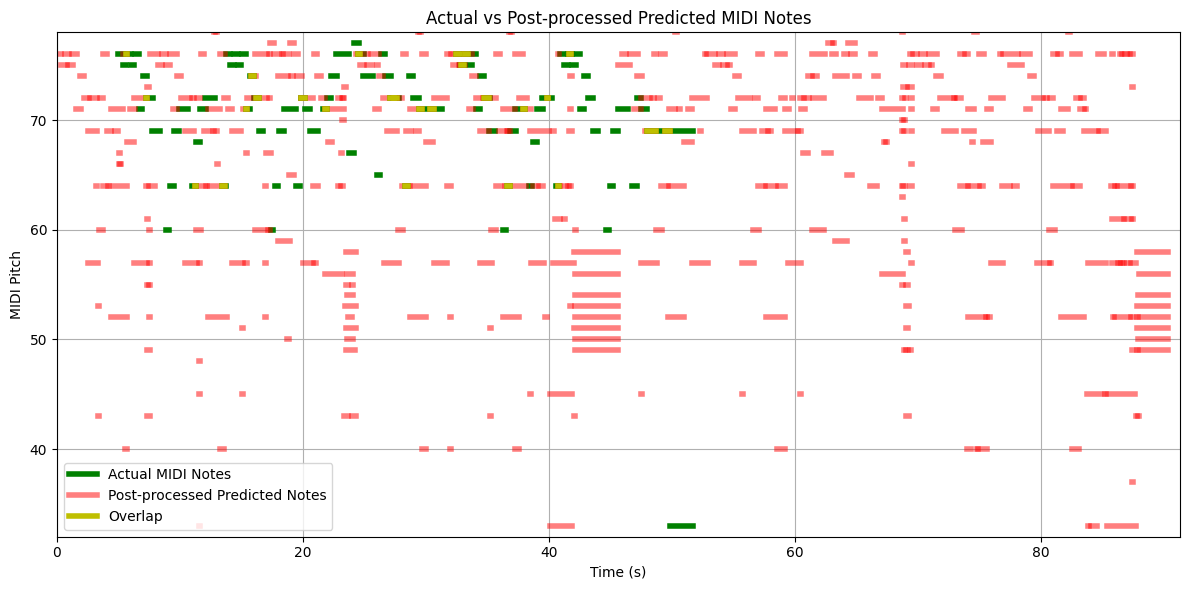

In [75]:
import numpy as np
import librosa
import pretty_midi
import matplotlib.pyplot as plt


data_dir = output_directory+"predictions_post_CQT_"+mode+".npy"
matY = np.load(data_dir)


y, sampleRate = librosa.load(audio_file_path, sr=None)  
original_midi = pretty_midi.PrettyMIDI(original_midi_path)
original_notes = original_midi.instruments[0].notes 


onset_frames = librosa.onset.onset_detect(y=y, sr=sampleRate, units='frames', backtrack=True)
onset_times = librosa.frames_to_time(onset_frames, sr=sampleRate)


frame_width = 512.0
sample_frequence = sampleRate
pitch = 20


predicted_pitches = []
predicted_start_times = []
predicted_end_times = []


for col in np.transpose(matY):
    startTime = 0.0
    endTime = 0.0
    pitch += 1
    status = False

    for idx, i in enumerate(col):
        if i > 0.5 and not status: 
            startTime = idx * frame_width / sample_frequence
            status = True
        if i < 0.1 and status: 
            endTime = idx * frame_width / sample_frequence
            status = False
            if endTime - startTime > 0.02:  
                predicted_start_times.append(startTime)
                predicted_end_times.append(endTime)
                predicted_pitches.append(pitch)

    if status:  
        endTime = (len(col) * frame_width - 0.5) / sample_frequence
        if endTime - startTime > 0.02:
            predicted_start_times.append(startTime)
            predicted_end_times.append(endTime)
            predicted_pitches.append(pitch)


plt.figure(figsize=(12, 6))
plt.title("Actual vs Post-processed Predicted MIDI Notes")


for note in original_notes:
    plt.plot([note.start, note.end], [note.pitch, note.pitch], lw=4, color='g', label='Actual MIDI Notes')


for start, end, pitch in zip(predicted_start_times, predicted_end_times, predicted_pitches):
    plt.plot([start, end], [pitch, pitch], lw=4, color='r', alpha=0.5, label='Post-processed Predicted Notes')


for note in original_notes:
    for start, end, pitch in zip(predicted_start_times, predicted_end_times, predicted_pitches):
        if note.start < end and note.end > start and note.pitch == pitch:  # Check for overlap
            overlap_start = max(note.start, start)
            overlap_end = min(note.end, end)
            plt.plot([overlap_start, overlap_end], [pitch, pitch], lw=4, color='y', label='Overlap')

plt.xlim(0, max(max(predicted_end_times), max([note.end for note in original_notes])) + 1)
plt.ylim(min([note.pitch for note in original_notes]) - 1, max([note.pitch for note in original_notes]) + 1)
plt.xlabel("Time (s)")
plt.ylabel("MIDI Pitch")
plt.grid(True)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()


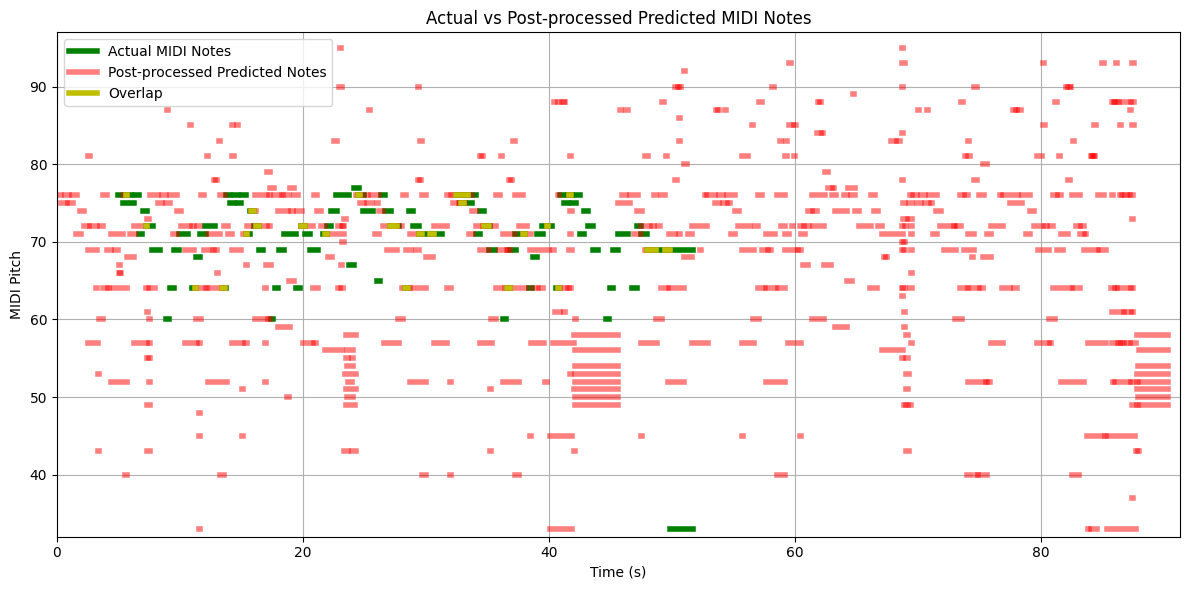

In [74]:
import numpy as np
import librosa
import pretty_midi
import matplotlib.pyplot as plt


data_dir = output_directory+"predictions_post_CQT_"+mode+".npy"
matY = np.load(data_dir)


y, sampleRate = librosa.load(audio_file_path, sr=None)  
original_midi = pretty_midi.PrettyMIDI(original_midi_path)
original_notes = original_midi.instruments[0].notes 

onset_frames = librosa.onset.onset_detect(y=y, sr=sampleRate, units='frames', backtrack=True)
onset_times = librosa.frames_to_time(onset_frames, sr=sampleRate)

frame_width = 512.0
sample_frequence = sampleRate
pitch = 20

predicted_pitches = []
predicted_start_times = []
predicted_end_times = []


for col in np.transpose(matY):
    startTime = 0.0
    endTime = 0.0
    pitch += 1
    status = False

    for idx, i in enumerate(col):
        if i > 0.5 and not status:  
            startTime = idx * frame_width / sample_frequence
            status = True
        if i < 0.1 and status:  
            endTime = idx * frame_width / sample_frequence
            status = False
            if endTime - startTime > 0.02: 
                predicted_start_times.append(startTime)
                predicted_end_times.append(endTime)
                predicted_pitches.append(pitch)

    if status:  
        endTime = (len(col) * frame_width - 0.5) / sample_frequence
        if endTime - startTime > 0.02:
            predicted_start_times.append(startTime)
            predicted_end_times.append(endTime)
            predicted_pitches.append(pitch)


all_pitches = [note.pitch for note in original_notes] + predicted_pitches
min_pitch = min(all_pitches) - 1
max_pitch = max(all_pitches) + 1


plt.figure(figsize=(12, 6))
plt.title("Actual vs Post-processed Predicted MIDI Notes")

for note in original_notes:
    plt.plot([note.start, note.end], [note.pitch, note.pitch], lw=4, color='g', label='Actual MIDI Notes')


for start, end, pitch in zip(predicted_start_times, predicted_end_times, predicted_pitches):
    plt.plot([start, end], [pitch, pitch], lw=4, color='r', alpha=0.5, label='Post-processed Predicted Notes')


for note in original_notes:
    for start, end, pitch in zip(predicted_start_times, predicted_end_times, predicted_pitches):
        if note.start < end and note.end > start and note.pitch == pitch:
            overlap_start = max(note.start, start)
            overlap_end = min(note.end, end)
            plt.plot([overlap_start, overlap_end], [pitch, pitch], lw=4, color='y', label='Overlap')

plt.xlim(0, max(max(predicted_end_times), max([note.end for note in original_notes])) + 1)


plt.ylim(min_pitch, max_pitch)

plt.xlabel("Time (s)")
plt.ylabel("MIDI Pitch")
plt.grid(True)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()

# Save plot as a PDF
output_pdf_path = f'/home/scar-face/Documents/GitHub/Thesis-live/EEE4022S-F project report template/Photos/{innermost_folder}' + " ap.pdf"
plt.savefig(output_pdf_path, format='pdf')

plt.show()
